# Imports

In [ ]:
import pennylane as qml
import torch
from qulearn.qlayer import AltRotCXLayer, HamiltonianLayer

num_qubits = 3
n_layers = 2
wires = range(0, num_qubits)
dev = qml.device("default.qubit", wires=wires, shots=None)
layer = AltRotCXLayer(wires, n_layers=n_layers, dtype=torch.float64)
obs = [qml.PauliZ(0)]
model = HamiltonianLayer(layer, observables=obs, qdevice=dev, dtype=torch.float64, interface="torch", diff_method="backprop")
loss_fn = torch.nn.MSELoss()
y = torch.tensor([-0.25], dtype=torch.float64)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
print(drawer())

In [ ]:
import numpy as np
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)
matrices = [np.kron(np.kron(a, b), c) for a in [I, Z] for b in [I, Z] for c in [I, Z]]
coefficients = np.random.rand(len(matrices))

M = sum(matrices[i]*coefficients[i] for i in range(2))
eigenvalues = np.linalg.eigvals(M)
print(eigenvalues)

In [ ]:
from torch.optim import Adam
opt = Adam(model.parameters(), lr=0.1)
opt.zero_grad()
pred = model()
loss = loss_fn(pred, y)
loss.backward()
opt.step()

In [ ]:
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
print(drawer())

In [259]:
def scalar2vector(x, L):
    # Check if input is within the expected range
    if not -1 <= x < 1:
        raise ValueError("x must be in the range [-1, 1)")
    if L <= 0:
        raise ValueError("L must be a positive integer")
    
    # Initialize binary and remainder variables
    binary = [0] * L
    reference = 0.0

    # Create binary variables
    for i in range(L):
        if x >= reference:
            binary[i] = 1
            if i < L-1:
                reference += 0.5**(i+1)
        else:
            if i < L-1:
                reference -= 0.5**(i+1)

    # Adjust remainder
    remainder = x - reference
    remainder *= 2 ** (L - 1)

    return (binary, remainder)

def vector2scalar(binary, remainder):
    L = len(binary)
    sum = -1.0
    for j, ij in enumerate(binary):
        sum += 2.0**(-j)*ij
        
    sum += remainder*2.0**(1-L)
    
    return sum

x = torch.tensor([0.8])
L = 3
vec = scalar2vector(x, L)
orig = vector2scalar(*vec)
print(x)
print(vec)
print(orig)

if x < 0:
    print("less than 0")
if x > 0:
    print("larger than 0")

tensor([0.8000])
([1, 1, 1], tensor([0.2000]))
tensor([0.8000])
larger than 0


In [258]:
from qulearn.qlayer import CircuitLayer
import pennylane as qml

class QTT1DEncoding(CircuitLayer):
    
    def __init__(self, wires, level):
        super().__init__(wires)
        self.level = level
        
    def circuit(self, x):
        binary, y = scalar2vector(x, self.level)
        
        for index, b in enumerate(binary):
            if b == 1:
                qml.PauliX(self.wires[index])
                
        qml.RZ(0.0, self.wires[-1])

In [ ]:
from qulearn.qlayer import CircuitLayer, AltRotCXLayer
import pennylane as qml
from pennylane import IQPEmbedding
import torch
from torch import nn

class Hadamards(CircuitLayer):
    
    def __init__(self, wires):
        super().__init__(wires)
        
    def circuit(self, x):
        for wire in self.wires:
            qml.Hadamard(wire)

class Exp1DEncoding(CircuitLayer):
    
    def __init__(self, wires):
        super().__init__(wires)
        
    def circuit(self, x):
        lrelu = torch.nn.LeakyReLU(0.01)
        for j, wire in enumerate(self.wires):
            x_ = torch.asin(lrelu(x))
            x_ = lrelu(x)
            x_ = 2**j*x
            qml.RZ(x_.item(), wire)
            
class ParallelIQPEncoding(CircuitLayer):
    
    def __init__(self, wires, num_features, omega = 1.0):
        super().__init__(wires)
        self.num_features = num_features
        self.omega = omega
        
        assert self.num_wires >= self.num_features
        assert self.num_wires % self.num_features == 0
        
    def circuit(self, x):
        num_features = x.shape[-1]
        assert num_features == self.num_features
        
        freq = 0
        for i in range(0, len(self.wires), num_features):
            x_ = 2**(freq*self.omega)*x
            qml.IQPEmbedding(x_, wires=self.wires[i: i+num_features])
            freq += 1
            
class ParallelEntangledIQPEncoding(CircuitLayer):
    
    def __init__(self, wires, num_features, omega = 1.0):
        super().__init__(wires)
        self.num_features = num_features
        self.omega = omega
        
        assert self.num_wires >= self.num_features
        assert self.num_wires % self.num_features == 0
        
    def circuit(self, x):
        num_features = x.shape[-1]
        assert num_features == self.num_features
        
        num_repeats = int(self.num_wires/num_features)
        
        x_large = []
        for j in range(0, num_repeats):
            x_ = 2**(j*self.omega)*x
            x_large.append(x_)
            
        x_final = torch.cat(x_large)
        qml.IQPEmbedding(x_final, wires=self.wires)
        

class QuantumKernel(nn.Module):
    
    def __init__(self, embed, X_train):
        super().__init__()
        self.embed = embed
        self.X_train = X_train
        self.num_samples = X_train.shape[0]
        self.alpha = nn.Parameter(
            torch.empty(
                self.num_samples,
                device=self.X_train.device,
                dtype=self.X_train.dtype,
            )
        )
        nn.init.normal_(self.alpha)
        
        self.qdevice = qml.device(wires=self.embed.wires, name="default.qubit", shots=None)
        self.qnode = self.set_qnode()
        
    
    def kernel_circ(self, x, x_):
        self.embed(x)
        qml.adjoint(self.embed)(x_)
        state = torch.zeros(self.embed.num_wires, dtype=torch.int32, device=x.device)
        projector = qml.Projector(state, self.embed.wires)
        return qml.expval(projector)
    
    def kernel_matrix(self, x, x_):
        # assert shape has length 2
        
        K = torch.empty((x.shape[0], x_.shape[0]), dtype=x.dtype, device=x.device)
        for i, xi in enumerate(x):
            for j, xj in enumerate(x_):
                Kij = self.qnode(xi, xj)
                K[i, j] = Kij
        return K
    
    def kernel_ridge_regression(self, labels, lambda_reg) -> None:
        # sets optimal alpha (closed form solution)
        K = self.kernel_matrix(self.X_train, self.X_train)
        I = torch.eye(self.num_samples, dtype=labels.dtype, device=labels.device)
        M = K+lambda_reg*I
        self.alpha = nn.Parameter(torch.linalg.solve(M, labels))
    
    def forward(self, x):
        K = self.kernel_matrix(x, self.X_train)
        out = torch.matmul(K, self.alpha)
        return out
    
    def set_qnode(self):
        circuit = self.kernel_circ
        qnode = qml.QNode(
            circuit,
            self.qdevice,
            interface="torch",
            diff_method="backprop"
        )
        self.qnode = qnode
        return self.qnode

In [ ]:
from enum import Enum
class Test(Enum):
    one = 1
    two = 2
    
print(Test.one.name)

In [ ]:
x1 = torch.tensor([[0.1]])
x2 = torch.tensor([[0.2]])
x3 = torch.tensor([[0.3]])
x = torch.cat((x1, x2, x3), dim=1)
print(x)
print(x.shape)

In [ ]:
import pennylane as qml
from qulearn.qlayer import ParallelEntangledIQPEncoding, ParallelIQPEncoding, MeasurementLayer, MeasurementType, IQPERYCZLayer, RYCZLayer
from qulearn.qkernel import QKernel
from qulearn.trainer import RidgeRegression
import torch
from torch.nn import MSELoss
import logging
from torch.utils.data import DataLoader, TensorDataset

num_features = 2
num_feature_repeat = 2
wires = num_features*num_feature_repeat
embed = ParallelEntangledIQPEncoding(wires, num_features=num_features, omega=1.0, n_repeat=2)
var = RYCZLayer(wires=wires, n_layers=1)
#embed = IQPERYCZLayer(wires=wires, num_uploads=1, num_varlayers=0, num_repeat=2, omega=1.0)
#embed = ParallelIQPEncoding(wires, num_features=1, omega=1.0, n_repeat=2)
obs = qml.PauliZ(0)
num_samples = 10
X_train = torch.randn((num_samples, num_features))
labels = torch.randn((num_samples, 1))
model = QKernel(embed, X_train)
#model = MeasurementLayer(var, embed, measurement_type=MeasurementType.Expectation, observable=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x1 = torch.tensor([0.1, 0.3])
x2 = torch.tensor([0.2, 0.3])
print(drawer(x1, x2))

# #test = model.qnode(x1, x2)
# test = model.kernel_matrix(X_train, X_train)
# print(test.shape)
# print(test)

# predicted = model(X_train)
# fn = MSELoss()
# loss_before = fn(predicted, labels)

# lambda_reg = 1.0
# metrics = {"mse_loss": fn}
# logger = logging.getLogger(__name__)
# logger.setLevel(level=logging.INFO)
# trainer = RidgeRegression(lambda_reg, metrics, logger)
# dataset = TensorDataset(X_train, labels)
# train_loader = DataLoader(dataset, batch_size=num_samples)
# valid_loader = DataLoader(dataset, batch_size=num_samples)
# trainer.train(model, train_loader, valid_loader)

# predicted = model(X_train)
# loss_after = fn(predicted, labels)

# print(f"Loss before: {loss_before} | Loss after: {loss_after}")

In [ ]:
print(model.alpha)

In [ ]:
X_train = torch.randn((num_samples, num_features))
model.X_train = X_train
print(model.alpha)

In [ ]:
for p in model.named_parameters():
    print(p)

In [ ]:
from qulearn.qlayer import HamiltonianLayer, AltRotCXLayer, IQPEmbeddingLayer
import torch

observables = [qml.PauliZ(0), qml.Identity(0)]#, qml.PauliZ(1), qml.PauliZ(2), qml.PauliZ(3)]
wires = 1*3
embed = ParallelEntangledIQPEncoding(wires, num_features=1)
#embed = ParallelIQPEncoding(wires, num_features=1)
varlayer1 = AltRotCXLayer(wires=3, n_layers=2)
varlayer2 = AltRotCXLayer(wires=3, n_layers=2)
model = HamiltonianLayer(varlayer1, embed, varlayer2, observables=observables)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")

x = torch.rand((1, 2))*2.0-1.0
x = torch.tensor([[-0.74]])
y = model(x)
print(y)
x_ = x[0]
print(drawer(x_))

In [ ]:
from qulearn.qlayer import HamiltonianLayer, AltRotCXLayer, IQPEmbeddingLayer
import torch

observables = [qml.PauliZ(0)]#, qml.PauliZ(1), qml.PauliZ(2), qml.PauliZ(3)]
#embed = QTT1DEncoding(wires=4, level=3)
#embed = IQPEmbeddingLayer(wires=1, n_repeat=1)
hads = Hadamards(wires=4)
embed = Exp1DEncoding(wires=4)
varlayer1 = AltRotCXLayer(wires=4, n_layers=2)
varlayer2 = AltRotCXLayer(wires=4, n_layers=2)
model = HamiltonianLayer(hads, varlayer1, embed, varlayer2, observables=observables)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")

x = torch.rand((1, 1))*2.0-1.0
x = torch.tensor([[-0.74]])
y = model(x)
print(y)
print(drawer(x))

In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def fourier_series(x, n, c):
    """
    Compute the truncated Fourier series evaluated at an input x.
    """
    k = torch.arange(-n, n+1)
    terms = c[k+n]*torch.exp(1j*k*x)
    y = torch.real(torch.sum(terms, dim=1))
    y = y/torch.max(torch.abs(y))
    return y

def generate_dataset(num_samples, n, c):
    """
    Generate a dataset of random samples x with corresponding y values evaluated 
    at x using a truncated Fourier series.
    """
    x = torch.rand(num_samples, 1, dtype=torch.float64)*2.0-1.0
    y = fourier_series(x, n, c)
    return x, y

def get_data_loader(x, y, batch_size=5):
    """
    Convert the dataset into a PyTorch DataLoader.
    """
    dataset = TensorDataset(x.unsqueeze(-1), y.unsqueeze(-1))
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

# Example usage:

n = 10  # Number of terms in the Fourier series
c_positive = torch.rand(n) + 1j*torch.rand(n)  # Random coefficients for positive k
c_negative = torch.conj(c_positive)  # Coefficients for negative k are the conjugate of those for positive k
c_positive = c_positive.flip(dims=[0])
c_zero = torch.rand(1)  # Coefficient for k=0 is just a real number
c = torch.cat((c_negative, c_zero, c_positive))

# Generate a dataset and data loader
x, y = generate_dataset(25, n, c)
y = torch.where(x <= 0, torch.tensor(0, dtype=torch.float64), torch.tensor(1, dtype=torch.float64))
dataloader = get_data_loader(x, y)

In [ ]:
import pennylane as qml
from qulearn.qlayer import MeasurementLayer, MeasurementType, IQPEAltRotCXLayer, HamiltonianLayer
num_features = 3
interface='torch'
diff_method='backprop'
qdev = qml.device("default.qubit", wires=num_features, shots=None)
circuit = IQPEAltRotCXLayer(wires=num_features, num_uploads=1, num_varlayers=1, num_repeat=3, omega=torch.tensor(0.0))
obs = qml.PauliZ(0)
model = HamiltonianLayer(circuit, observables=[obs], qdevice=qdev, interface=interface, diff_method=diff_method)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.randn(num_features)
print(drawer(x))

In [ ]:
from torch.optim import Adam
from qulearn.trainer import SupervisedTrainer
import logging
opt = Adam(model.parameters(), lr=0.1, amsgrad=True)
loss_fn = torch.nn.MSELoss()
logger = logging.getLogger("SupTrainer")
logger.setLevel(level=logging.INFO)
trainer = SupervisedTrainer(opt, loss_fn, num_epochs=50, logger=logger)

In [ ]:
trainer.train(model, dataloader, dataloader)

In [ ]:
from qulearn.fat import fat_shattering_dim
from qulearn.datagen import DataGenFat, UniformPrior
prior = UniformPrior(sizex=num_features, seed=0)
gamma=0.1
datagen = DataGenFat(prior=prior, Sb=10, Sr=5, gamma=2.0*gamma, seed=0, batch_size=25)

In [ ]:
dim = fat_shattering_dim(model, datagen=datagen, trainer=trainer, dmin=1, dmax=100, gamma=gamma, dstep=1)

In [ ]:
from qulearn.fat import check_shattering
#check = check_shattering(model, datagen, trainer, 1, gamma=gamma)
#print(check)
print(dim)

In [ ]:
print(dim)
data = datagen.gen_data(1)
loader = datagen.data_to_loader(data, 0, 1)
for x, y in loader:
    print(x)
    print(y)
print(data["b"])
print(data["r"])
print(0.07260766+gamma*2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(-10, 10, 1000)  # Generate 1000 points between -10 and 10

# Calculate y values for each function
y_cos = np.cos(x)
y_cos_x2 = np.cos(x**2)
y_cos_x2 = np.cos(x) + 0.5*np.sin(4*x)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(x, y_cos, label="cos(x)", color="blue")
plt.plot(x, y_cos_x2, label="cos(x^2)", color="red")

# Adding title and labels
plt.title("Plot of cos(x) and cos(x^2)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sympy import symbols, Matrix, cos, sin, exp
from sympy.physics.quantum import TensorProduct as kron

# ParameterVectors
nx = 1
ntheta = 3*1  # Adjust this for the number of parameters you need
x = symbols('x0:{}'.format(ntheta))
theta = symbols('theta0:{}'.format(ntheta))
omega = symbols('omega')

# Initial state |0>
ket_0 = Matrix([[1], [0]])


# Non-Parametric Gates
H = 1/2**0.5 * Matrix([
    [1, 1],
    [1, -1]
])
Z = Matrix([
    [1, 0],
    [0, -1]
])
CX = Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])
I = Matrix.eye(2)

# Parametric Gates
RZ = Matrix([
    [exp(-1j*x[0]/2), 0],
    [0, exp(1j*x[0]/2)]
])
U3 = Matrix([
    [cos(theta[0]/2), -exp(1j*theta[2])*sin(theta[0]/2)],
    [exp(1j*theta[1])*sin(theta[0]/2), exp(1j*(theta[1] + theta[2]))*cos(theta[0]/2)]
])
#RZZ = exp(-1j*theta/2*kron(Z, Z))

# Apply the Rz gate to the initial state
psi = U3 * RZ * H * ket_0

# Compute the expectation value of Z
expectation = (psi.H * Z * psi)
expectation[0]

In [ ]:
from sympy import symbols, Matrix, cos, sin, exp
from sympy.physics.quantum import TensorProduct as kron

# ParameterVectors
nx = 1
ntheta = 3*2  # Adjust this for the number of parameters you need
x = symbols('x0:{}'.format(ntheta))
theta = symbols('theta0:{}'.format(ntheta))
omega = symbols('omega')

# Initial state |0>
ket_0 = Matrix([[1], [0]])


# Non-Parametric Gates
H = 1/2**0.5 * Matrix([
    [1, 1],
    [1, -1]
])
Z = Matrix([
    [1, 0],
    [0, -1]
])
CX = Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])
I = Matrix.eye(2)

# Parametric Gates
RZ_1 = Matrix([
    [exp(-1j*x[0]/2), 0],
    [0, exp(1j*x[0]/2)]
])
RZ_2 = Matrix([
    [exp(-1j*(2**(omega))*x[1]/2), 0],
    [0, exp(1j*(2**(omega))*x[1]/2)]
])

offset = 0
U3_1 = Matrix([
    [cos(theta[0+offset]/2), -exp(1j*theta[2+offset])*sin(theta[0+offset]/2)],
    [exp(1j*theta[1+offset])*sin(theta[0+offset]/2), exp(1j*(theta[1+offset] + theta[2+offset]))*cos(theta[0+offset]/2)]
])
offset = 3
U3_2 = Matrix([
    [cos(theta[0+offset]/2), -exp(1j*theta[2+offset])*sin(theta[0+offset]/2)],
    [exp(1j*theta[1+offset])*sin(theta[0+offset]/2), exp(1j*(theta[1+offset] + theta[2+offset]))*cos(theta[0+offset]/2)]
])
#RZZ = exp(-1j*theta/2*kron(Z, Z))

# Apply the Rz gate to the initial state
psi = U3_2 * RZ_2 * H * U3_1 * RZ_1 * H * ket_0

# Compute the expectation value of Z
expectation = (psi.H * Z * psi)
expectation[0]

In [ ]:
from sympy import symbols, Matrix, cos, sin, exp
from sympy.physics.quantum import TensorProduct as kron

# ParameterVectors
nx = 1
ntheta = 3*4  # Adjust this for the number of parameters you need
x = symbols('x0:{}'.format(ntheta))
theta = symbols('theta0:{}'.format(ntheta))
omega = symbols('omega')

# Initial state |0>
ket_0 = Matrix([[1], [0]])


# Non-Parametric Gates
H = 1/2**0.5 * Matrix([
    [1, 1],
    [1, -1]
])
Z = Matrix([
    [1, 0],
    [0, -1]
])
CX = Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])
I = Matrix.eye(2)

# Parametric Gates
RZ_1 = Matrix([
    [exp(-1j*x[0]/2), 0],
    [0, exp(1j*x[0]/2)]
])
RZ_2 = Matrix([
    [exp(-1j*(2**(omega))*x[1]/2), 0],
    [0, exp(1j*(2**(omega))*x[1]/2)]
])

offset = 0
U3_1 = Matrix([
    [cos(theta[0+offset]/2), -exp(1j*theta[2+offset])*sin(theta[0+offset]/2)],
    [exp(1j*theta[1+offset])*sin(theta[0+offset]/2), exp(1j*(theta[1+offset] + theta[2+offset]))*cos(theta[0+offset]/2)]
])
offset = 3
U3_2 = Matrix([
    [cos(theta[0+offset]/2), -exp(1j*theta[2+offset])*sin(theta[0+offset]/2)],
    [exp(1j*theta[1+offset])*sin(theta[0+offset]/2), exp(1j*(theta[1+offset] + theta[2+offset]))*cos(theta[0+offset]/2)]
])
offset = 6
U3_3 = Matrix([
    [cos(theta[0+offset]/2), -exp(1j*theta[2+offset])*sin(theta[0+offset]/2)],
    [exp(1j*theta[1+offset])*sin(theta[0+offset]/2), exp(1j*(theta[1+offset] + theta[2+offset]))*cos(theta[0+offset]/2)]
])
offset = 9
U3_4 = Matrix([
    [cos(theta[0+offset]/2), -exp(1j*theta[2+offset])*sin(theta[0+offset]/2)],
    [exp(1j*theta[1+offset])*sin(theta[0+offset]/2), exp(1j*(theta[1+offset] + theta[2+offset]))*cos(theta[0+offset]/2)]
])
#RZZ = exp(-1j*theta/2*kron(Z, Z))

# Apply the Rz gate to the initial state
psi = kron(U3_3, U3_4) * CX * kron(U3_1, U3_2) * kron(RZ_1, RZ_2) * kron(H, H) * (kron(ket_0, ket_0))

# Compute the expectation value of Z
expectation = (psi.H * kron(Z, I) * psi)
expectation[0]

In [16]:
import pennylane as qml
from qulearn.qlayer import AltRotCXLayer, ParallelEntangledIQPEncoding, ParallelIQPEncoding, MeasurementLayer, MeasurementType, IQPERYCZLayer, RYCZLayer, IQPEAltRotCXLayer, HadamardLayer, HamiltonianLayer, IQPEmbeddingLayer
from qulearn.qkernel import QKernel
from qulearn.trainer import RidgeRegression
import torch
from torch.nn import MSELoss
import logging
from torch.utils.data import DataLoader, TensorDataset

num_features = 11
num_feature_repeat = 1
wires = num_features*num_feature_repeat
#embed = ParallelEntangledIQPEncoding(wires, num_features=num_features, omega=1.0, n_repeat=1)
#embed = ParallelIQPEncoding(wires, num_features=num_features, omega=1.0, n_repeat=1)
embedvar = IQPEAltRotCXLayer(wires=wires, num_uploads=1, num_varlayers=1, num_repeat=1, omega=1.0)
embed = IQPEmbeddingLayer(wires=wires, n_repeat=1)
hads = HadamardLayer(wires=wires)
var = AltRotCXLayer(wires=wires, n_layers=4)
#embed = IQPERYCZLayer(wires=wires, num_uploads=1, num_varlayers=0, num_repeat=2, omega=1.0)
#embed = ParallelIQPEncoding(wires, num_features=1, omega=1.0, n_repeat=2)
obs = [qml.Identity(0), qml.PauliZ(0)]
num_samples = 100
#X_train = torch.randn((num_samples, num_features))
labels = torch.randn((num_samples, 1))

qdevice = qml.device("lightning.qubit", wires=wires, shots=None)
interface = "torch"
diff_method = "adjoint"

#model = QKernel(embed, X_train)
#model = MeasurementLayer(embedvar, measurement_type=MeasurementType.Entropy, observable=obs)
#model = MeasurementLayer(embedvar, measurement_type=MeasurementType.Expectation, observable=obs)
#level = 11
#wires = level
#embed = QTT1DEncoding(wires, level=level)
#var1 = AltRotCXLayer(wires=wires, n_layers=121)
#var2 = AltRotCXLayer(wires=wires, n_layers=5)
#var3 = AltRotCXLayer(wires=wires, n_layers=5)
#var4 = AltRotCXLayer(wires=wires, n_layers=5)
embed1 = IQPEmbeddingLayer(wires=wires, n_repeat=1)
embed2 = IQPEmbeddingLayer(wires=wires, n_repeat=1)
embed3 = IQPEmbeddingLayer(wires=wires, n_repeat=1)
embed4 = IQPEmbeddingLayer(wires=wires, n_repeat=1)
embed5 = IQPEmbeddingLayer(wires=wires, n_repeat=1)
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x1 = 2*torch.rand(num_features) - 1
x2 = torch.tensor([0.2, 0.3])
print(x1)
print(drawer(x1))
#model.subwires = [0, 1]
#print(model(x1))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(qml.specs(model.qnode)(x1))

tensor([ 0.8196, -0.7071,  0.5968,  0.8793, -0.9459,  0.1620,  0.5459, -0.4880,
         0.8995, -0.1265,  0.2839])
 0: ──H──RZ(0.82)──╭MultiRZ(-0.58)─╭MultiRZ(0.49)─╭MultiRZ(0.72)─╭MultiRZ(-0.78)─╭MultiRZ(0.13)
 1: ──H──RZ(-0.71)─╰MultiRZ(-0.58)─│──────────────│──────────────│───────────────│─────────────
 2: ──H──RZ(0.60)──────────────────╰MultiRZ(0.49)─│──────────────│───────────────│─────────────
 3: ──H──RZ(0.88)─────────────────────────────────╰MultiRZ(0.72)─│───────────────│─────────────
 4: ──H──RZ(-0.95)───────────────────────────────────────────────╰MultiRZ(-0.78)─│─────────────
 5: ──H──RZ(0.16)────────────────────────────────────────────────────────────────╰MultiRZ(0.13)
 6: ──H──RZ(0.55)──────────────────────────────────────────────────────────────────────────────
 7: ──H──RZ(-0.49)─────────────────────────────────────────────────────────────────────────────
 8: ──H──RZ(0.90)──────────────────────────────────────────────────────────────────────────────
 9: ──H──RZ(-0.13)──

In [251]:
from torch import nn
class ExtendedModel(nn.Module):
    def __init__(self, original_model):
        super(ExtendedModel, self).__init__()
        self.original_model = original_model
    
    def forward(self, x):
        # Apply arcsin to each component of X
        x = torch.asin(x)
        
        # Pass the transformed X to the original model
        return self.original_model(x)
    
extended = ExtendedModel(model)
model = extended

In [233]:
# First, let's import necessary packages
import torch
import torch.nn as nn
import torch.nn.functional as F

input_dim = num_features
# Define the LeakyReLU network
class LeakyReLUNet(nn.Module):
    def __init__(self, input_dim):
        super(LeakyReLUNet, self).__init__()
        # Define layers of the network (You can adjust the number of neurons as needed)
        dim = 4
        self.fc1 = nn.Linear(input_dim, dim, dtype=torch.float64)  # First fully connected layer
        self.fc2 = nn.Linear(dim, dim, dtype=torch.float64)         # Second fully connected layer
        self.fc3 = nn.Linear(dim, dim, dtype=torch.float64)
        self.fc4 = nn.Linear(dim, dim, dtype=torch.float64)
        self.fc5 = nn.Linear(dim, 1, dtype=torch.float64)          # Output layer

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        return self.fc5(x)

# Initialize the network
model = LeakyReLUNet(input_dim)

# Print the model architecture
print(model)
print([p.shape for p in model.parameters() if p.requires_grad])
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

LeakyReLUNet(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=4, bias=True)
  (fc5): Linear(in_features=4, out_features=1, bias=True)
)
[torch.Size([4, 2]), torch.Size([4]), torch.Size([4, 4]), torch.Size([4]), torch.Size([4, 4]), torch.Size([4]), torch.Size([4, 4]), torch.Size([4]), torch.Size([1, 4]), torch.Size([1])]
77


In [ ]:
from torchviz import make_dot
# Create a random tensor to represent a sample input
x = torch.randn(1, input_dim)  # Assuming a batch size of 1
y = model(x)

# Visualize the network
make_dot(y, params=dict(model.named_parameters())).render("network", format="png")

In [17]:
import numpy as np
from qulearn.qlayer import MeasurementType
x = torch.rand(num_features)*2-1
subsystems = [list(range(i+1)) for i in range(wires-1)]
entropies = []
model.measurement_type = MeasurementType.Entropy
for subsystem in subsystems:
    model.subwires = subsystem
    entropies.append(model(x).item())
max_entropies = [np.log2(min(2**len(subsystem), 2**(wires - len(subsystem)))) for subsystem in subsystems]
print(x)

tensor([-0.2031, -0.7268,  0.0638, -0.0924, -0.6575,  0.6475,  0.3814,  0.1750,
        -0.5587, -0.4272,  0.0179])


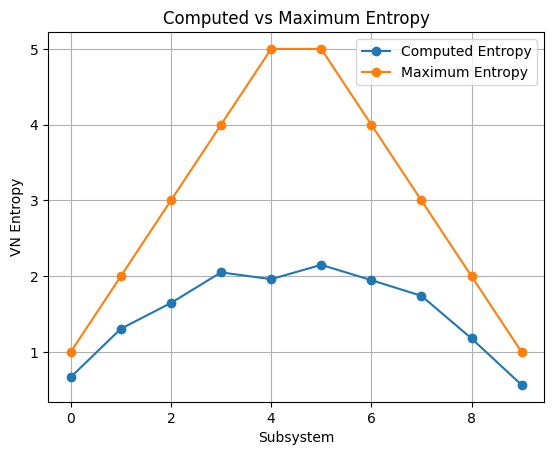

In [18]:
# Plotting
import matplotlib.pyplot as plt
x = list(range(wires-1))
plt.plot(x, entropies, '-o', label='Computed Entropy')
plt.plot(x, max_entropies, '-o', label='Maximum Entropy')

plt.xlabel('Subsystem')
plt.ylabel('VN Entropy')
plt.legend()
plt.grid(True)
plt.title('Computed vs Maximum Entropy')
plt.show()

In [218]:
import torch

# Generate a sample of inputs
X = torch.linspace(-1, 1, 1000).reshape(-1, 1)

# Define a function to add Gaussian noise
def add_gaussian_noise(tensor, mean=0., std=0.1):
    return tensor + torch.randn(tensor.size()) * std + mean

# 1. Linear Relationship
def linear(X, m=2, c=3):
    return m * X + c
Y_linear = add_gaussian_noise(linear(X))

# 2. Polynomial Relationship (Quadratic for demonstration)
def polynomial(X, a=3, b=2, c=-5):
    return a * X**2 + b * X + c
Y_polynomial = add_gaussian_noise(polynomial(X))

# 3. Exponential Relationship
def exponential(X, a=2, b=0.5):
    return a * torch.exp(b * X)
Y_exponential = add_gaussian_noise(exponential(X))

# 4. Logarithmic Relationship
def logarithmic(X, a=3, b=2):
    return a * torch.log(X) + b
Y_logarithmic = add_gaussian_noise(logarithmic(X))

# 5. Trigonometric Relationship
def trigonometric(X, a=5, b=2, c=0.5):
    return a * torch.sin(b * X + c)
Y_trigonometric = add_gaussian_noise(trigonometric(X))

# 6. Power-law Relationship
def power_law(X, a=2, b=1.5):
    return a * X**b
Y_power_law = add_gaussian_noise(power_law(X))

# 7. Sigmoidal Relationship
def sigmoidal(X, L=1, k=0.5, x0=5):
    return L / (1 + torch.exp(-k * (X - x0)))
Y_sigmoidal = add_gaussian_noise(sigmoidal(X))

# 8. Gaussian Relationship
def gaussian(X, a=3, b=4, c=2):
    return a * torch.exp(-((X - b) ** 2) / (2 * c ** 2))
Y_gaussian = add_gaussian_noise(gaussian(X))

# 9. Step Function
def step_function(X, threshold1=-0.5, threshold2=0.5, low_value=-1, mid_value=1, high_value=0):
    condition1 = (X < threshold1)
    condition2 = (X >= threshold1) & (X < threshold2)
    condition3 = (X >= threshold2)

    values = torch.zeros_like(X)
    values[condition1] = low_value
    values[condition2] = mid_value
    values[condition3] = high_value
    
    return values

Y_step = add_gaussian_noise(step_function(X))

def piecewise_linear_3segments(X, a=-1, b=1, m1=2, c1=0, m2=-3, m3=1):
    # Define linear functions for each segment
    linear_before_a = m1 * X + c1
    linear_between_a_b = m1 * a + c1 + m2 * (X - a)
    linear_after_b = m1 * a + c1 + m2 * (b - a) + m3 * (X - b)
    
    # Apply conditions for each segment
    conditions = [(X < a), (X >= a) & (X < b), (X >= b)]
    functions = [linear_before_a, linear_between_a_b, linear_after_b]

    output = torch.zeros_like(X)
    for condition, function in zip(conditions, functions):
        output[condition] = function[condition]
    
    return output
Y_piecewise_spiked = add_gaussian_noise(piecewise_linear_3segments(X))

def multidimstep(X, a=1.0):
    # Extract the first and second features
    X0 = X[:, 0]
    X1 = X[:, 1]

    # Check the condition X[1] > a * X[0]
    condition = X1 > a * X0

    # Initialize the output tensor Y
    Y = torch.zeros_like(X1)

    # Set Y values based on the condition
    Y[condition] = 1  # Set to +1 where condition is True
    Y[~condition] = -1  # Set to -1 where condition is False
    
    return Y.view(-1, 1)  # Reshape to make it a column vector

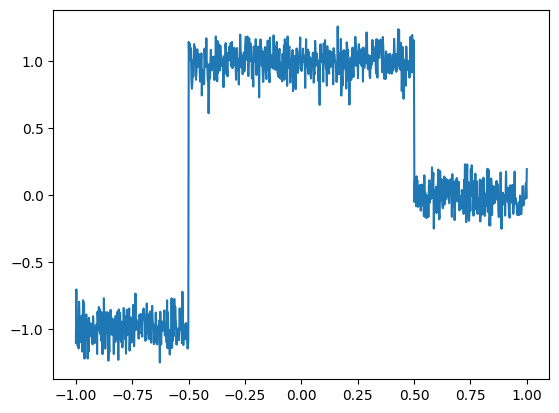

In [214]:
# Create the scatter plot
plt.plot(X, Y_step)

# Show the plot
plt.show()

In [254]:
import torch
import logging
from torch.optim import Adam
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset

# Data
N_train = 100
N_valid = 10
batch_size=25
#X_train = torch.linspace(-1, 1, N_train, dtype=torch.float64).reshape(-1, 1)
X_train = torch.rand((N_train, num_features), dtype=torch.float64)
Y_train = add_gaussian_noise(multidimstep(X_train))
#X_valid = torch.linspace(-1, 1, N_valid, dtype=torch.float64).reshape(-1, 1)
X_valid=  torch.rand((N_valid, num_features), dtype=torch.float64)
Y_valid = multidimstep(X_valid)
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=False)

# Trainer
lr = 0.1
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
loss_fn = torch.nn.MSELoss()
logger = logging.getLogger("train_function")
logger.setLevel(level=logging.INFO)
num_epochs = 200
trainer = SupervisedTrainer(optimizer=optimizer,
                            loss_fn=loss_fn,
                            num_epochs=num_epochs,
                            logger=logger)

In [255]:
# Train
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 1.008990, Metrics: 
INFO:train_function:Validate - Epoch: 1, Loss: 1.006878, Metrics: 
INFO:train_function:Train - Epoch: 2, Loss: 1.006462, Metrics: 
INFO:train_function:Validate - Epoch: 2, Loss: 0.940793, Metrics: 
INFO:train_function:Train - Epoch: 3, Loss: 0.937803, Metrics: 
INFO:train_function:Validate - Epoch: 3, Loss: 0.881224, Metrics: 
INFO:train_function:Train - Epoch: 4, Loss: 0.771938, Metrics: 
INFO:train_function:Validate - Epoch: 4, Loss: 0.991138, Metrics: 
INFO:train_function:Train - Epoch: 5, Loss: 0.600574, Metrics: 
INFO:train_function:Validate - Epoch: 5, Loss: 1.331589, Metrics: 
INFO:train_function:Train - Epoch: 6, Loss: 0.448343, Metrics: 
INFO:train_function:Validate - Epoch: 6, Loss: 1.520128, Metrics: 
INFO:train_function:Train - Epoch: 7, Loss: 0.360695, Metrics: 
INFO:train_function:Validate - Epoch: 7, Loss: 1.154959, Metrics: 
INFO:train_function:Train - Epoch: 8, Loss: 0.300834, Metrics: 
INFO:train_function

In [215]:
from qulearn.trainer import RidgeRegression
lambda_reg = 1e-01
loader_train = DataLoader(data_train, batch_size=N_train, shuffle=False)
loss_fn = torch.nn.MSELoss()
metrics = {"mse_loss": loss_fn}
trainer = RidgeRegression(lambda_reg=lambda_reg, metrics=metrics, logger=logger)
trainer.train(model, loader_train, loader_train)

INFO:train_function:Train - Metrics: mse_loss: 0.004280
INFO:train_function:Validate - Metrics: mse_loss: 0.004280


In [273]:
# Plotting
X = torch.linspace(-1, 1, 1000, dtype=torch.float64).reshape(-1, 1)
Y_exact = step_function(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10,6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")

# Adding title and labels
plt.title("Exact vs. Model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: x must be in the range [-1, 1)

In [ ]:
import torch
import matplotlib.pyplot as plt

# assuming model is your pytorch model
# model = ...

# Generate 100 random inputs between -1 and 1
inputs = torch.linspace(-2, 2, 100)
inputs = inputs.unsqueeze(-1)

# Ensure the model is in evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # Run the inputs through the model
    outputs = model(inputs)

# Convert tensors to numpy arrays for plotting
inputs = inputs.numpy()
outputs = outputs.numpy()

# Create the scatter plot
plt.scatter(inputs, outputs)
#plt.scatter(x, y)

# Show the plot
plt.show()

In [ ]:
import sys
sys.path.append("/home/mazen/Research/QC/QuLearn/examples/compare_models")
from model_builder import QNNModel, QNNStatModel

In [ ]:
model = QNNStatModel(num_features=1, num_reuploads=1, num_varlayers=1, num_repeats=1, omega=0.0, double_wires=False, id="0")
for p in model.parameters():
    print(p)

In [ ]:
import pennylane as qml
import torch
drawer = qml.draw(model.qnn.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.randn(1, 1)
print(model(x))
print(drawer(x))

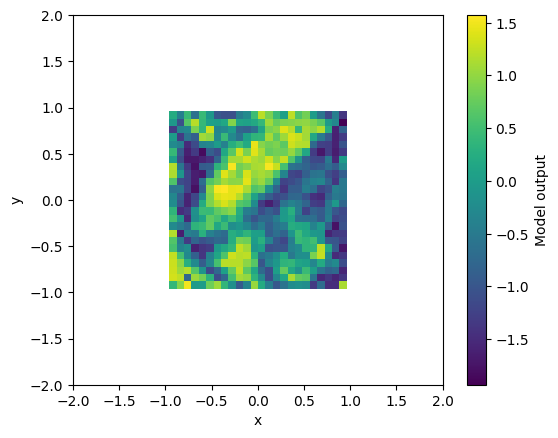

In [256]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# assuming model is your PyTorch model
# model = ...

# Ensure the model is in evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # Define input range
    x = np.linspace(-2, 2, 50)
    y = np.linspace(-2, 2, 50)
    X, Y = np.meshgrid(x, y)

    # Combine inputs and reshape for model input
    inputs = np.array([X.flatten(), Y.flatten()]).T
    inputs = torch.tensor(inputs, dtype=torch.float64)

    # Compute outputs
    with torch.no_grad():
        outputs = model(inputs)
        #outputs = multidimstep(inputs)

    # Convert tensors to numpy arrays for plotting
    inputs = inputs.numpy()
    outputs = outputs.numpy()

    # Reshape output for heatmap
    Z = outputs.reshape(50, 50)

    # Create the heatmap
    plt.imshow(Z, extent=[-2, 2, -2, 2], origin='lower')
    plt.colorbar(label='Model output')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

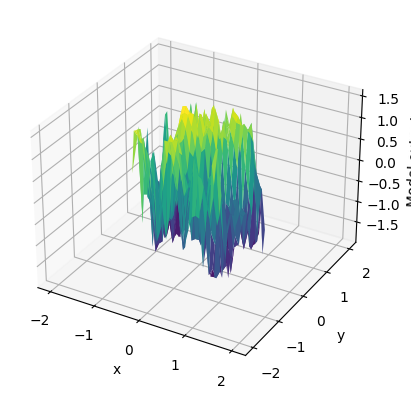

In [257]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Model output')

# Show the plot
plt.show()

In [ ]:
import numpy as np
from scipy.stats import qmc

def generate_lhs_samples(n_samples, n_dims, lower_bound, upper_bound):
    """Generates Latin Hypercube Samples in the specified range."""
    sampler = qmc.LatinHypercube(d=n_dims)
    sample = sampler.random(n=n_samples)
    return lower_bound + sample * (upper_bound - lower_bound)

import torch

def generate_model_samples(model, n_samples):
    """Generates a list of lists of model parameters, sampled using LHS."""
    model_parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

    lower_bound = -2 * np.pi
    upper_bound = 2 * np.pi
    samples = []
    for p in model_parameters:
        n_dims = p.numel()
        sample_parameter = generate_lhs_samples(n_samples=n_samples, n_dims=n_dims, lower_bound=lower_bound, upper_bound=upper_bound)
        samples.append(sample_parameter)
    parameter_list = [[torch.tensor(samples[j][i], device=None, dtype=None) for j in range(len(samples))] for i in range(n_samples)]

    return parameter_list

In [ ]:
test = generate_model_samples(model, 5)
print(len(test))
for t in test:
    print(len(t))
    for x in t:
        print(x.shape)

In [ ]:
for input, label in dataloader:
    print(input)
    print(label)
    break

In [ ]:
import logging
logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)
logger.info("hello world")

In [ ]:
import torch
print(torch.__version__)

In [ ]:
from qulearn.qlayer import IQPEmbeddingLayer
from qulearn.qlayer import QEvalType
import torch
import pennylane as qml
from qulearn.observable import parity_all_hamiltonian 

numq = 3
wires = range(numq)
qdev = qml.device("lightning.qubit", wires=numq, shots=None)
@qml.qnode(qdev)
def qnode():
    return qml.expval(qml.PauliZ(0))

out = qnode()
print(out)
print(qdev.shots)

In [ ]:
import torch
import math
t = torch.nn.Parameter(torch.zeros(3, 3))
print(t)
torch.nn.init.uniform_(t, a=0.0, b=2*math.pi)
print(t)
a = [0, 1]
b = [0, 2]
print(a==b)

In [ ]:
from qulearn.qlayer import IQPEmbeddingLayer, RYCZLayer, MeasurementLayer, HamiltonianLayer, MeasurementType, EmbedVarLayer, CircuitLayer
import pennylane as qml
import torch
from qulearn.observable import parities_all_observables

observable = qml.PauliZ(0)
num_wires = 3
num_reup = 1
num_layers = 1
num_repeat = 1
qdev = qml.device('default.qubit', wires=num_wires, shots=None)

upload_layer = IQPEmbeddingLayer(num_wires, num_reup)
var_layer = RYCZLayer(num_wires, num_layers)
embedvar = EmbedVarLayer(upload_layer, var_layer, n_repeat=num_repeat, omega=1.0)
measure_layer = MeasurementLayer(embedvar, qdevice=qdev, measurement_type=MeasurementType.Expectation, observable=observable)
obs = parities_all_observables(num_wires)
ham_layer = HamiltonianLayer(embedvar, observables=obs, interface='torch', diff_method='backprop')
#ham_layer = HamiltonianLayer(upload_layer, observables=obs)

x = torch.randn(3, num_wires)
drawer = qml.draw_mpl(ham_layer.qnode, show_all_wires=True, expansion_strategy="device")
drawer(x)


In [ ]:
y = torch.cat((x, x), dim=1)
print(x)
print(y)

In [ ]:
from qulearn.utils import all_bin_sequences
from qulearn.observable import sequence2parity_observable
from itertools import combinations
all = all_bin_sequences(3)
pairs = list(combinations(range(3),2 ))
print(all)
print(pairs)
all_obs = sequence2parity_observable(all)
pairs_obs = sequence2parity_observable(pairs)

print(all_obs)
print(pairs_obs)
all_obs[0].name

In [ ]:
print(tuple(range(3)))

In [ ]:
for p in ham_layer.parameters():
    print(p)
print(ham_layer.observable.coeffs)
print(ham_layer.observable)

In [ ]:
tmp = torch.tensor([1., -1., 0.5])
print(tmp.numel())

In [ ]:
from qulearn.fim import empirical_fim, compute_fims, mc_integrate_idfim_det

FIM = empirical_fim(measure_layer, x)
for p in measure_layer.parameters():
    print(p)

plist = []
p1 = torch.randn(4, 3)
p2 = torch.randn(4, 3, 2, 2)
for i in range(4):
    plist.append([p1[i], p2[i]])

FIMs = compute_fims(measure_layer, x, plist)

In [ ]:
integral = mc_integrate_idfim_det(FIMs, 1.0, 1.0)
print(integral)

In [ ]:
lin = torch.nn.Linear(3, 1)
print(lin(x))

In [ ]:
y1 = upload_layer(x)
y2 = var_layer(x)
#y3 = measure_layer(x)
y4 = ham_layer(x)

print(y3)
print(y4)

In [ ]:
import torch
print(y3)
log_prob = torch.log(y3)
print(torch.log(y3))
print(x.shape)

measure_layer.zero_grad()
log_prob.backward(retain_graph=True)
grad_list = [
    p.grad.view(-1)
    for p in measure_layer.parameters()
    if p.requires_grad and p.grad is not None
]
grad = torch.cat(grad_list)
prod = torch.outer(grad, grad)

In [ ]:
for key, val in measure_layer.state_dict().items():
    print(key)
    print(val)
    print("====")

print("************************************")

for key, val in ham_layer.state_dict().items():
    print(key)
    print(val)
    print("====")

In [ ]:
from torch import nn
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.ll_in = nn.Linear(3, 3, dtype=torch.float64)
        self.meas = ham_layer
        self.ll_out = nn.Linear(1, 1, dtype=torch.float64)

    def forward(self, x):

        y = self.ll_in(x)
        y = self.meas(y)
        y = self.ll_out(y)

        return y
    
hybrid = HybridModel()
x = torch.rand(3, dtype=torch.float64)
y = hybrid(x)
print(y)
for key, val in hybrid.state_dict().items():
    print(key)
    print(val)
    print("======")

In [ ]:
print(y)

In [ ]:
for key, val in measure_layer.state_dict().items():
    print(key)
    print(val)
    print("=====")

In [ ]:
from enum import Enum

class MyType(Enum):

    TypeA = 0
    TypeB = 1

x = MyType.TypeA
y = "blub"

if x == MyType.TypeA:
    print(x)

if not isinstance(y, MyType):
    raise NotImplementedError("QEvalType not implemented")

In [ ]:
import torch
from torch.nn import Linear
model = Linear(3, 1)
X = torch.tensor([[0.1, 1.1, -2.2], [0.6, 4.1, -3.2], [-0.1, -2.1, -2.2]])
Y = model(X)
print(Y.shape)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/test")
for i in range(10):
    val = 1e-01
    writer.add_scalar("foobar1", val, i)
    writer.add_scalars("loss", {"train": val, "valid": val+1.0}, i)
writer.close()

In [ ]:
import torch
import pennylane as qml
from qml_mor.models import IQPEReuploadSU2Parity, ModelType
from torch.utils.data import TensorDataset, DataLoader

num_samples=1
num_qubits = 3
num_reups = 1
num_layers = 1
sizex = num_qubits

omega = 0.0
init_theta = torch.randn(num_reups, num_qubits, requires_grad=True)
theta = torch.randn(
    num_reups, num_layers, num_qubits - 1, 2, requires_grad=True
)
W = torch.randn(2**num_qubits, requires_grad=True)

params = [init_theta, theta, W]

dev = qml.device("default.qubit", wires=num_qubits, shots=None)

model = IQPEReuploadSU2Parity(dev, params, model_type=ModelType.Expectation)
X = torch.randn(10, 3)
Ypred = model(X)
print(Ypred)
print(Ypred.shape)

loss = torch.nn.MSELoss()
test = loss(Ypred, Ypred)
print(test)

In [ ]:
from torch.nn import Parameter
P = model.parameters()
for p in P:
    print(p)
print("====================")
save = model.state_dict().copy()

init_theta = torch.randn(num_reups, num_qubits, requires_grad=True)
theta = torch.randn(
    num_reups, num_layers, num_qubits - 1, 2, requires_grad=True
)
W = torch.randn(2**num_qubits, requires_grad=True)

params = [init_theta, theta, W]

model = IQPEReuploadSU2Parity(dev, params)

P = model.parameters()
for p in P:
    print(p)
print("====================")
model.load_state_dict(save)
P = model.parameters()
for p in P:
    print(p)
print("====================")
print(save)

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
from qulearn.qlayer import IQPEmbeddingLayer, RYCZLayer, MeasurementLayer, HamiltonianLayer, MeasurementType, EmbedVarLayer, CircuitLayer
import pennylane as qml
import torch
from qulearn.observable import parities_all_observables

observable = qml.PauliZ(0)
num_wires = 3
num_reup = 1
num_layers = 1
num_repeat = 3
qdev = qml.device('default.qubit', wires=num_wires, shots=None)

upload_layer = IQPEmbeddingLayer(num_wires, num_reup)
var_layer = RYCZLayer(num_wires, num_layers)
embedvar = EmbedVarLayer(upload_layer, var_layer, n_repeat=num_repeat, omega=1.0)
obs = parities_all_observables(num_wires)
ham_layer = HamiltonianLayer(embedvar,  qdevice=qdev, observables=obs, interface='torch', diff_method='adjoint')

x = torch.zeros(3, num_wires)
print(ham_layer(x))

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
N = 100
torch.manual_seed(0)
X = torch.randn(N, 10, dtype=torch.float64)
#Y = torch.randn(N, 1, dtype=torch.float64)
A = torch.randn(10, 1, dtype=torch.float64)
b = torch.randn(1, dtype=torch.float64)
eps = torch.randn(N, dtype=torch.float64)*0.001
Y = torch.matmul(X, A) + b + eps
model = torch.nn.Linear(10, 1, bias=True, dtype=torch.float64)
batch_size=4
shuffle=True

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
from torch.optim import Adam
from qulearn.trainer import SupervisedTrainer
import logging
from torch.utils.tensorboard import SummaryWriter
opt = Adam(model.parameters(), lr=0.1, amsgrad=True)
loss_fn = torch.nn.MSELoss()
metrics = {"L1": loss_fn, "L2": loss_fn}
writer = SummaryWriter()
logger = logging.getLogger("SupTrainer")
logger.setLevel(level=logging.INFO)
trainer = SupervisedTrainer(opt, loss_fn, metrics, 200, logger=logger)

In [ ]:
trainer.train(model, loader, loader)

In [ ]:
%%timeit
trainer.train(ham_layer, loader, loader) # lightning + torch + adjoint (+ omp-num-threads=8)

In [ ]:
%%timeit
trainer.train(ham_layer, loader, loader) # default + torch + backprop

In [ ]:
%%timeit
trainer.train(ham_layer, loader, loader) # default + torch + adjoint

In [ ]:
%lprun -T lprof0 -u 1.0 -f trainer._train_step trainer.train(ham_layer, loader, loader)
writer.close()

In [ ]:
from enum import Enum

class MeasurementType(Enum):
    """Measurement type for a measurement layer."""

    """Expectation: return expected value of observable."""
    Expectation
    """Probabilities: return vector of probabilities."""
    Probabilities = "probabilities"
    """Samples: return measurement samples."""
    Samples = "samples"

example = MeasurementType.Expectation
print(type(example.name))

In [ ]:
from qml_mor.trainer import RegressionTrainer
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam
from datetime import datetime

optimizer = Adam(model.parameters(), lr=0.1, amsgrad=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/check_{}'.format(timestamp))
loss_fn = torch.nn.MSELoss()
training = RegressionTrainer(optimizer, loss_fn, writer)
loss = training.train(model, loader, loader)
print(loss)
writer.close()

In [ ]:
path = "model_bestmre"
state = torch.load(path)
model.load_state_dict(state)
Ypred = model(X)
print(Y)
print("==============")
print(Ypred)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/fashion_trainer_20230517_113403

In [ ]:
import torch
import pennylane as qml
from torch.utils.data import TensorDataset, DataLoader
from qml_mor.models import IQPEReuploadSU2Parity
from qml_mor.trainer import AdamTorch
from qml_mor.datagen import DataGenCapacity

num_samples=1
num_qubits = 3
num_reups = 1
num_layers = 1
sizex = num_qubits

datagen = DataGenCapacity(sizex=sizex, num_samples=num_samples)

omega = 0.0
init_theta = torch.randn(num_reups, num_qubits, requires_grad=True)
theta = torch.randn(
    num_reups, num_layers, num_qubits - 1, 2, requires_grad=True
)
W = torch.randn(2**num_qubits, requires_grad=True)

params = [init_theta, theta, W]

model = IQPEReuploadSU2Parity(omega)
dev = qml.device("default.qubit", wires=num_qubits, shots=None)

@qml.qnode(dev, interface="torch")
def qnn_model(x, params):
    return model.qfunction(x, params)

loss_fn = torch.nn.MSELoss()
num_epochs = 300
opt = AdamTorch(params, loss_fn, num_epochs=num_epochs, amsgrad=True)

N = 10
batch_size=int("inf")
shuffle=True
data = datagen.gen_data(N)
X = data["X"]
Y = data["Y"][0]
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

opt_params = opt.optimize(qnn_model, loader)

In [ ]:
Nx = X.size(0)
y_pred = torch.stack([qnn_model(X[k], opt_params) for k in range(Nx)])
mre = torch.mean(torch.abs((Y - y_pred) / y_pred))

print(mre)
print(loss_fn(y_pred, Y))

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
X = torch.randn(5, 3)
Y = torch.randn(5)
batch_size = 2

dataset = TensorDataset(X, Y)
shuffle = True
loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

print(X)
print(Y)
print("===========")
for X_, Y_ in loader:
    print(X_.size(0))
    print(X_)
    print(Y_)
    print("***********")

In [ ]:
from qml_mor.datagen import DataGenRademacher, NormalPrior
prior = NormalPrior(3, seed=0)
radem = DataGenRademacher(prior, 2, 3, seed=None)
data = radem.gen_data(4)
print(data)

In [ ]:
import torch
import pennylane as qml
num_qubits = 3
W = torch.randn(2**num_qubits, requires_grad=False)
from qulearn.qlayer import parity_hamiltonian
H = parity_hamiltonian(num_qubits, W)
print(W)
print("======")
Z = qml.PauliZ(wires=0)
print(H.coeffs.requires_grad)
W_ = torch.nn.Parameter()
print(W_)

In [ ]:
import pennylane as qml
import torch
from qml_mor.models import IQPEReuploadSU2Parity

num_qubits  = 3
num_reps    = 2
num_layers  = 2
omega       = 1.
torch.manual_seed(0)
x           = torch.randn(num_qubits, requires_grad=False)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)

params = [init_theta, theta, W]

def iqpe_reupload_su2_parity(
    x, init_theta, theta, W, omega: float = 0.0
):
    """
    Quantum function that calculates the expectation value
    of the parity of Pauli Z operators.

    Args:
        x (Tensor): Input tensor of shape (num_qubits,)
        init_theta (Tensor): Initial rotation angles for each qubit,
            of shape (reps, num_qubits)
        theta (Tensor): Rotation angles for each layer and each qubit,
            of shape (reps, num_layers, num_qubits-1, 2)
        W (Tensor): Observable weights of shape (2^num_qubits,)
        omega (float, optional): Exponential feature scaling factor. Defaults to 0.0.

    Returns:
        QFuncOutput: Expectation value of the parity of Pauli Z operators
    """

    shape_init = init_theta.shape
    shape = theta.shape
    if len(shape_init) != 2:
        raise ValueError("Initial theta must be a 2-dim tensor")
    if len(shape) != 4:
        raise ValueError("Theta must be a 4-dim tensor")

    num_qubits = len(x)
    reps = shape_init[0]
    wires = range(num_qubits)

    for layer in range(reps):
        features = 2 ** (omega * layer) * x
        initial_layer_weights = init_theta[layer]
        weights = theta[layer]

        qml.IQPEmbedding(features=features, wires=wires)
        qml.SimplifiedTwoDesign(
            initial_layer_weights=initial_layer_weights,
            weights=weights,
            wires=wires,
        )

def iqpe_reupload_su2_meas(
    x, init_theta, theta, W, omega: float = 0.0
):
    iqpe_reupload_su2_parity(x, init_theta, theta, W, omega)
    obs = parities(len(x))
    H = qml.Hamiltonian(W, obs)

    return qml.sample()

#qnn_model = IQPEReuploadSU2Parity(params, omega=1.0)

dev = qml.device("default.qubit", wires=num_qubits, shots=None)
qnode = qml.QNode(iqpe_reupload_su2_meas, dev, interface="torch")
#drawer = qml.draw(qnode, expansion_strategy="device")
#print(drawer(x, init_theta, theta, W))
probs = qnode(x, init_theta, theta, W, omega)
probs

In [ ]:
samples = probs
bitstrings = [''.join(str(b.item()) for b in sample) for sample in samples]
bitstring_counts = {bs: bitstrings.count(bs) for bs in set(bitstrings)}
print(samples)
print(bitstrings)
print(bitstring_counts)

In [ ]:
from qml_mor.models import IQPEReuploadSU2Parity

model = IQPEReuploadSU2Parity()

qnode = qml.QNode(model.probabilities, dev, interface="torch")
probs = qnode(x, params)
print(probs)
print(model.Hamiltonian(params))

In [ ]:
H = model.Hamiltonian(params)
sum = 0.0
b = "110"

for idx, O in enumerate(H.ops):

    if not isinstance(O.name, list):
        if O.name == "Identity":
            sum += H.coeffs[idx]
        elif O.name == "PauliZ":
            i = O.wires[0]
            sign = (-1)**(int(b[-1-i]))
            sum += sign*H.coeffs[idx]
        else:
            raise ValueError("All operators must be PauliZ or Identity.")
    else:
        if not all(name=="PauliZ" for name in O.name):
            raise ValueError("All operators must be PauliZ or Identity.")
        
        sign = 1
        for w in O.wires:
            sign *= (-1)**(int(b[-1-w]))

        sum += sign*H.coeffs[idx]

In [ ]:
print(probs)
marginal = qml.math.marginal_prob(probs, axis=[0])
print(marginal)

In [ ]:
from qml_mor.models import parities

n = 3
test = parities(n)
H = qml.Hamiltonian(W, test)
print(H)
print(H.ops)

# Model Definition

In [ ]:
# feature layer
def feature_layer(x):
    num_qubits = len(x)
    qml.IQPEmbedding(x, wires=range(num_qubits))

In [ ]:
# variational layer
def variational_layer(init_theta, theta, num_qubits):
    qml.SimplifiedTwoDesign(initial_layer_weights=init_theta, weights=theta, wires=range(num_qubits))

In [ ]:
# observable / output layer
def sequence_generator(n):
    if n == 0:
        return [[]]
    else:
        sequences = []
        for sequence in sequence_generator(n-1):
            sequences.append(sequence + [n-1])
            sequences.append(sequence)
        return sequences
    
def parities(n):
    
    seq = sequence_generator(n)
    ops = []
    for par in seq:
        if par:
            tmp = qml.PauliZ(par[0])
            if len(par) > 1:
                for i in par[1:]:
                    tmp = tmp @ qml.PauliZ(i)

            ops.append(tmp)

    ops.append(qml.Identity(0))

    return ops

In [ ]:
from pennylane.templates import IQPEmbedding, SimplifiedTwoDesign
# QNN model
@qml.qnode(dev, interface='torch')
def qnn_model(x, init_theta, theta, W, omega=0.):

    num_qubits = len(x)
    shape_init = init_theta.shape
    reps       = 1
    if len(shape_init) < 1:
        init_theta = [init_theta]
        shape_init = init_theta.shape
    reps       = shape_init[0]

    shape_theta = theta.shape
    reps_       = 1
    if len(shape_theta) < 3:
        theta       = [theta]
        shape_theta = theta.shape
    reps_       = shape_theta[0]

    assert reps == reps_
    for l in range(reps):
        qml.IQPEmbedding(features=2**(omega*l)*x, wires=range(num_qubits))
        qml.SimplifiedTwoDesign(initial_layer_weights=init_theta[l], weights=theta[l], wires=range(num_qubits))

    obs = parities(num_qubits)
    H   = qml.Hamiltonian(W, obs)

    return qml.expval(H)

In [ ]:
import pennylane as qml
from pennylane.templates import IQPEmbedding

n_wires = 3
n_layers = 2

dev = qml.device("default.qubit", wires=n_wires)
@qml.qnode(dev, interface='torch')
def iqpe_circuit(features):
    for layer in range(n_layers):
        # Apply the IQPEmbedding template in a loop
        IQPEmbedding(features=features[layer], wires=range(n_wires))

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_wires)]

features = np.random.random((n_layers, n_wires))

result1 = iqpe_circuit(features)

In [ ]:
num_qubits  = 3
num_reps    = 0
num_layers  = 0
omega       = 1.
x           = torch.randn(num_qubits, requires_grad=False)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)

result1 = qnn_model(x, init_theta, theta, W)
result2 = qnn_model(x, init_theta, theta, W)

ret = torch.stack([result1, result2])
result1.size()

In [ ]:
from scipy.stats import qmc
def generate_samples_r(d, S):
    sampler = qmc.LatinHypercube(d=d)
    r_samples = sampler.random(n=S)
    return r_samples
r = generate_samples_r(10, 2)
print(len(r[0]))

tmp = set()
rng = np.random.default_rng(seed=0)
b1 = tuple(rng.integers(0, 2, size=4))
b2 = tuple(rng.integers(0, 2, size=4))
tmp.add(b1)
tmp.add(b2)
print(tmp)
arr = np.array(list(tmp))
print(arr)
arr[0, 3]

In [ ]:
import torch

# Original list of tensors
tensor_list = [torch.tensor([1., 2., 3.], requires_grad=True),
               torch.tensor([4., 5., 6.], requires_grad=False)]

est_params = [
                        t.detach().clone().requires_grad_(t.requires_grad)
                        for t in tensor_list
                    ]
tensor_list *= 2
print(tensor_list)
print(est_params)

In [ ]:
msg = (f"Stopping early\n"
       "Loss not improving")
print(msg)

In [ ]:
import pennylane as qml
import torch
import torch.optim as optim
import torch.nn as nn

# Define the quantum device
dev = qml.device("default.qubit", wires=2)

# Define the custom model as a PennyLane QNode
@qml.qnode(dev, interface="torch")
def custom_model(x, y):
    # Apply your quantum circuit here, which uses input x and trainable parameters y
    # As an example, we'll use a simple circuit with one rotation gate parameterized by y:
    qml.RY(y[0], wires=0)
    qml.RX(x, wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(1))

# Define the dataset (x_data, y_data)
x_data = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5], dtype=torch.float32)
y_data = torch.tensor([0.5, 0.4, 0.3, 0.2, 0.1], dtype=torch.float32)

# Initialize the trainable parameters
params = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)

# Set the hyperparameters
learning_rate = 0.01
epochs = 100
loss_fn = nn.MSELoss()
optimizer = optim.Adam([params], lr=learning_rate)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    predictions = torch.tensor([custom_model(x, params) for x in x_data], dtype=torch.float32)
    loss = loss_fn(predictions, y_data)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

print(f"Trained parameters: {params}")

In [ ]:
num_qubits  = 3
num_reps    = 3
num_layers  = 0
omega       = 1.
x           = torch.randn(num_qubits, requires_grad=False)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)
def qnn_model(x, init_theta, theta, W, omega=0.):

    num_qubits = len(x)
    shape_init = init_theta.shape
    reps       = 1
    if len(shape_init) < 1:
        init_theta = [init_theta]
        shape_init = init_theta.shape
    reps       = shape_init[0]

    shape_theta = theta.shape
    reps_       = 1
    if len(shape_theta) < 3:
        theta       = [theta]
        shape_theta = theta.shape
    reps_       = shape_theta[0]

    assert reps == reps_
    for l in range(reps):
        qml.IQPEmbedding(features=2**(omega*l)*x, wires=range(num_qubits))
        qml.SimplifiedTwoDesign(initial_layer_weights=init_theta[l], weights=theta[l], wires=range(num_qubits))

    obs = parities(num_qubits)
    H   = qml.Hamiltonian(W, obs)

    return qml.expval(H)

result = qnn_model(x, init_theta, theta, W)
print(result.shape())

In [ ]:
tmp = parities(3)
for x in tmp:
    print(type(x))
    print(issubclass(type(x), qml.operation.Observable))

In [ ]:
# example
num_qubits  = 3
num_reps    = 3
num_layers  = 0
omega       = 1.
x           = torch.randn(num_qubits, requires_grad=False)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)

print(qml.draw_mpl(qnn_model)(x, init_theta, theta, W, omega))

# Datasets for Capacity Estimation

In [ ]:
def gen_dataset(N, samples=10, seed=0):
    sizex   = num_qubits
    scale   = 2.
    shift   = -1.

    torch.manual_seed(seed)
    x       = scale*torch.rand(N, sizex, requires_grad=False) + shift
    y       = scale*torch.rand(samples, N, requires_grad=False) + shift

    return x, y

# Training

In [ ]:
# model specs
num_qubits  = 3
num_reps    = 2
num_layers  = 2
omega       = 1.

In [ ]:
import this

In [ ]:
# initial parameters
seed = 0
torch.manual_seed(seed)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)

In [ ]:
# loss function
def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

In [ ]:
# capacity estimation parameters
Nmin     = 1
Nmax     = 5
samples  = 10
steps    = 300
eps_stop = 1e-12

In [ ]:
summary = {}
for N in range(Nmin, Nmax):
    x, y = gen_dataset(N, samples)
    
    mre_sample = []
    for s in range(samples):
        print('===================================')
        def cost(init_theta, theta, W):
            pred = [qnn_model(x[k], init_theta, theta, W) for k in range(N)]
            loss = square_loss(y[s], pred)
            return loss
        
        # optimize
        opt = torch.optim.Adam([init_theta, theta, W], lr=0.1, amsgrad=True)
        for n in range(steps):
            opt.zero_grad()
            loss = cost(init_theta, theta, W)
            loss.backward()
            opt.step()

            if n%10 == 9 or n == steps - 1:
                print(f'{n+1}: {loss}')

            if loss <= eps_stop:
                break

        # compute prediction errors
        y_pred = torch.tensor([qnn_model(x[k], init_theta, theta, W) for k in range(N)], requires_grad=False)
        mre    = torch.mean(torch.abs((y[s]-y_pred)/y_pred))
        mre_sample.append(mre)

    mre_N = torch.mean(torch.tensor(mre_sample))
    summary[f'N = {N}'] = mre_N.item()

In [ ]:
for count, eps in enumerate(summary.values()):
    m = int(np.log2(1./eps.item()))
    C = (count+1)*m
    print(C)
print(torch.numel(init_theta))

In [ ]:
C = [-0.5, 13.1, 2]
max(C)

# Summary

In [ ]:
y_pred = torch.tensor([qnn_model(x[k], init_theta, theta, W) for k in range(N)], requires_grad=False)
mre    = torch.mean(torch.abs((y[s]-y_pred)/y_pred))
print(mre.item())

In [ ]:
# cutoff precision converted to bits of precision
cutoff = np.sqrt(eps_stop)
m      = np.log2(1./cutoff)
print(m)

In [ ]:
print(x)
print(init_theta)
print(theta)
print(W)
print(y[s])
print(y_pred)